In [80]:
import mlflow
import mlflow.tensorflow
import pandas as pd
import numpy as np
import argparse
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.datasets.mnist import load_data
import os
import datetime
import uuid
import time
import logging
from hyperopt import (fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials)
idx = pd.IndexSlice
%load_ext autoreload
%autoreload

# Data process

In [3]:
# INPUTS
DATA_PATH = '/Users/camilovelasquez/Desktop/Documents/Datasets/WISDM-Smartphones/wisdm-dataset/raw'
ids = np.arange(1600, 1650)
devices = ['phone']
sensors = ['accel']
activities = ['A', 'B']
time_taken = 3000
time_split = 100

In [4]:
train_batch_size = 8
eval_batch_size = 16
epochs = 5

train_size = 2500
valid_size = 220
test_size = 220

In [5]:
# Preprocessing data
def read_WISDM_data(DATA_PATH, ids=np.arange(1600, 1650), 
                    devices=['phone'], sensors=['accel']):
    """Read from DATA PATH and create a pandas table from it"""
    i = 0
    for current_id in ids:
        for current_device in devices:
            for current_sensor in sensors:
                file_path = os.path.join(DATA_PATH, current_device, current_sensor, 
                                         'data_{}_{}_{}.txt'.format(current_id, current_sensor, current_device))
                if i==0:
                    table = pd.read_csv(file_path, delimiter=',', 
                                        names=['ID', 'Activity Label', 'Timestamp', 'x', 'y', 'z'], 
                                        lineterminator='\n')
                else:
                    aux = pd.read_csv(file_path, delimiter=',', 
                                      names=['ID', 'Activity Label', 'Timestamp', 'x', 'y', 'z'], 
                                        lineterminator='\n')
                    table = pd.concat([table, aux], axis=0)
                i+=1
    table.loc[:,'z'] = table.z.str.replace(';','').astype(np.float32)
    return table

def transform_data(table, time_taken, time_split):
    """Transform data from raw table into a zip of (features, labels),
        where features has shape (samples, time_steps, features), and labels (samples,)"""
    table = table.set_index(['ID', 'Activity Label'])
    table = table.groupby(['ID', 'Activity Label']).head(time_taken)
    timestamp_edit = np.tile(np.arange(0,time_split), int(table.shape[0]/time_split))
    table['Timestamp'] = timestamp_edit
    table = table.reset_index().set_index(['ID', 'Activity Label', 'Timestamp'], append=True)
    features = table.values.reshape((int(table.shape[0]/time_split), time_split, table.shape[1]))
    labels = table.reset_index()['Activity Label']\
        .values[np.arange(0,int(table.shape[0]/time_split)*time_split, time_split)]
    return features, labels

def preprocessing_data(table, time_taken=3000, time_split=100, activities=['A', 'B']):
    """Preprocess table and convert it into tf dataset"""
    features, labels = transform_data(table, time_taken=time_taken, time_split=time_split)
    dataset = tf.data.Dataset.from_tensor_slices(({'feature': features}, {'label': labels}))
    ds = dataset.filter(lambda x, y: tf.reduce_any(tf.equal(y['label'], activities))==True)
    ds = ds.map(label2prob)
    return ds

def label2prob(feature, label):
    new_label = tf.where(tf.equal(label['label'], 'A'), 1, 0)
    label['label'] = new_label
    return feature, label

In [6]:
table = read_WISDM_data(DATA_PATH, ids=ids, devices=devices, sensors=sensors)
ds = preprocessing_data(table, time_taken=time_taken, time_split=time_split, activities=activities)

# Adding params

In [7]:
params = {'sampling': hp.choice('sampling', [
                                {'type' : 'under', 
                                 'low_perc' : hp.choice('low_perc', [0.1, 0.2, 0.3])},
                                {'type' : 'over', 
                                 'low_perc' : hp.choice('low_perc', [0.1, 0.2, 0.3])}]),
          'batch_size' : hp.choice('batch_size', [64, 128, 256]),
          'test_mode' : True,
          'weighted' : hp.choice('weighted', [None, 'regular', 'double']),
          'eval_batch_size' : 256,
          'optimizer': hp.choice('optimizer', [
              {'type': 'adam', 
               'lr' : hp.loguniform('lr_mult', -1, 3)}, 
              {'type' : 'SGD', 
               'lr' :  hp.loguniform('lr_mult', -1, 3)} ]),
          'loss': hp.choice('loss', [
              {'type': 'binary_crossentropy'}, 
              {'type' : 'focal_loss', 
               'alpha' :  hp.uniform('alpha', -1, 3), 
               'gamma' : hp.choice('gamma', [0.5, 0.75, 1.0])} ]),
         }

In [8]:
params = {'batch_size' : hp.choice('batch_size', [8, 16, 32]), 
          'weighted' : hp.choice('weighted', [True, False]), 
          'layer_1' : hp.choice('layer_1', [{'kernel_1': hp.choice('kernel_1', [7, 11, 15, 19, 23, 27]), 
                                             'filters_1' : hp.choice('filters_1', [16, 32, 64, 128])}]), 
          'layer_2' : hp.choice('layer_2', [{'kernel_2': hp.choice('kernel_2', [7, 11, 15, 19, 23, 27]), 
                                             'filters_2' : hp.choice('filters_2', [16, 32, 64, 128])}])}

In [12]:
EXPERIMENT_NAME = 'testing_with_hyper_opt_final_tf'
#mlflow.set_tracking_uri(URI) # If you have an instance
mlflow.set_experiment(EXPERIMENT_NAME)
print("Experiment Name: ", EXPERIMENT_NAME)

INFO: 'testing_with_hyper_opt_final_tf' does not exist. Creating a new experiment
Experiment Name:  testing_with_hyper_opt_final_tf


# Building params

In [13]:
#Model params
def build_model(time_split, params):
    inputs = tf.keras.Input(shape=(time_split, 3), name='feature')
    x = tf.keras.layers.BatchNormalization(axis=2)(inputs)
    x_1 = tf.keras.layers.Conv1D(filters=params['layer_1']['filters_1'], 
                                 kernel_size=params['layer_1']['kernel_1'])(x)
    x_1 = tf.keras.layers.GlobalMaxPool1D()(x_1)
    x_3 = tf.keras.layers.Conv1D(filters=params['layer_2']['filters_2'], 
                                 kernel_size=params['layer_2']['kernel_2'])(x)
    x_3 = tf.keras.layers.GlobalMaxPool1D()(x_3)
    x_5 = tf.keras.layers.Conv1D(filters=32, kernel_size=63)(x)
    x_5 = tf.keras.layers.GlobalMaxPool1D()(x_5)
    x = tf.keras.layers.Concatenate()([x_1, x_3, x_5])
    x = tf.keras.layers.Dense(16, activation='relu')(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='label')(x)
    model = tf.keras.Model(inputs=[inputs], outputs=output)
    return model

def build_optimizer():
    optimizer='adam'
    return optimizer

def build_loss():
    loss='binary_crossentropy'
    return loss

def build_metrics():
    metrics=['accuracy']
    return metrics

def compile_model(model, optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']):
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

def train_model(model, train_ds=None, valid_ds=None):
    model.fit()

def save_summary(line, file='model_summary.txt'):
    with open(file, 'a') as f:
        f.write(line +'\n')
    
def build_class_weights(weight_type):
    if weight_type:
        class_weight = {1: 0.8, 0: 0.2}
    else:
        class_weight = None
    return class_weight

In [14]:
def build_callbacks(params):
    callbacks = []
    if 'es' in params['train']['params']['callbacks']:
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                               patience=5,
                                               mode='max',
                                               restore_best_weights=True)
        callbacks.append(es_callback)
    elif 'cp' in params['train']['params']['callbacks']:
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         verbose=1)
        callbacks.append(cp_callback)
    return callbacks

In [15]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                               patience=5,
                                               mode='max',
                                               restore_best_weights=True)
callbacks = [es_callback]

In [16]:
def transform_key_value_pair(kv_pairs, key, dictionary):
    if type(dictionary) is dict:
        for new_key, new_value in dictionary.items():
            if key is not None:
                transform_key_value_pair(kv_pairs, key + '_' + str(new_key), new_value)
            else:
                transform_key_value_pair(kv_pairs, new_key, new_value)    
    else:
        kv_pairs[key] = dictionary
        
def example(**args):
    print(args)
    for arg in args:
        print(arg)

In [135]:
def objetive(params):
    print('params: ',params)
    summary_filename = 'summary.txt'
    if os.path.exists(summary_filename):
        os.remove(summary_filename)
    run_name = 'model_' + str(uuid.uuid4())[:5]
    with mlflow.start_run(run_name=run_name) as run:
        out_run = run.to_dictionary()
        print(out_run['info']['run_id'])
        mlflow.tensorflow.autolog()
        new_params = dict()
        transform_key_value_pair(new_params, None, params)
        #Model
        model = build_model(time_split=time_split, params=params)
        optimizer = build_optimizer()
        loss = build_loss()
        metrics = build_metrics()
        model = compile_model(model=model, optimizer=optimizer, loss=loss, metrics=metrics)
        # model.summary(line_length=150, positions=[0.33, .55, .67, 1.],print_fn = lambda x: save_summary(x, file=summary_filename))
        
        #Build dataset
        ds_train = ds.take(train_size)
        ds_train = ds_train.repeat(count=epochs)
        ds_train = ds_train.batch(params['batch_size'])
        ds_train = ds_train.prefetch(1)

        ds_valid = ds.skip(train_size).take(valid_size)
        ds_valid = ds_valid.repeat(count=1)
        ds_valid = ds_valid.batch(params['batch_size'])
        ds_valid = ds_valid.prefetch(1)

        ds_test = ds.skip(train_size+valid_size)
        ds_test = ds_test.batch(eval_batch_size)
        
        #Train
        
        history = model.fit(ds_train, 
                    validation_data=ds_valid,
                    steps_per_epoch=train_size//params['batch_size'],  
                    epochs=epochs, 
                    callbacks=callbacks,
                    verbose=1, 
                    class_weight=build_class_weights(params['weighted']),
                    shuffle=False)
        # Metrics
        mlflow.log_metric('val_accuracy', max(history.history['val_accuracy']))
        for k, v in new_params.items():
            mlflow.log_param(k, v)
        # Artifacts
        tf.keras.backend.clear_session()
        
        mlflow.end_run()
    return {'loss': -max(history.history['val_accuracy']), 'status': STATUS_OK}

In [136]:
trials = Trials()
_ = fmin(objetive, params, trials=trials, algo=tpe.suggest, max_evals=1)

params:                                              
{'batch_size': 8, 'layer_1': {'filters_1': 128, 'kernel_1': 11}, 'layer_2': {'filters_2': 16, 'kernel_2': 15}, 'weighted': False}
c7a0d59839114c60883f3b4fab0381c8                     
Train for 312 steps                                  
Epoch 1/5                                            
  1/312 [..............................]             
 - ETA: 4:54 - loss: 0.9015 - accuracy: 0.0000e+00   
                                                    
  8/312 [..............................]             
 - ETA: 38s - loss: 0.7140 - accuracy: 0.4219        
                                                     
 16/312 [>.............................]             
 - ETA: 20s - loss: 0.6823 - accuracy: 0.5000        
                                                     
 23/312 [=>............................]             
 - ETA: 14s - loss: 0.6455 - accuracy: 0.6413        
                                                     
 31/312

 - 3s 9ms/step - loss: 0.1709 - accuracy: 0.9459 - val_loss: 0.5158 - val_accuracy: 0.7409

Epoch 3/5                                            
 1/28 [>.............................]               
 - ETA: 0s - loss: 0.0993 - accuracy: 1.0000         
                                                    
 9/28 [========>.....................]               
 - ETA: 0s - loss: 0.0200 - accuracy: 1.0000         
                                                    
17/28 [=================>............]               
 - ETA: 0s - loss: 0.0175 - accuracy: 1.0000         
                                                    
25/28 [=========================>....]               
 - ETA: 0s - loss: 0.0190 - accuracy: 1.0000         
                                                    
312/28 [==========================================================================================================================================================================================================

# Experiment LR Scheduler

In [3]:
import matplotlib.pyplot as plt

def loguniform(low=0, high=1, size=None):
    return np.exp(np.random.uniform(low, high, size))

In [72]:
x = loguniform(low=-10.4, high=-2.8, size=2000)

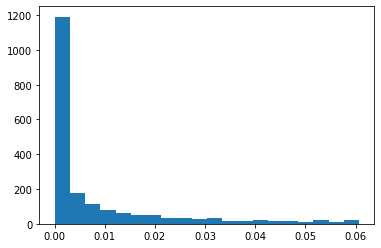

In [73]:
plt.hist(x, bins=20)
plt.show()

In [74]:
print("Min: {:.8f}, Max: {}".format(x.min(), x.max()))

Min: 0.00003051, Max: 0.06069313998961354


In [39]:
x = np.random.lognormal(-6, 1, 500)

In [119]:
x.mean()

0.004330304497495597

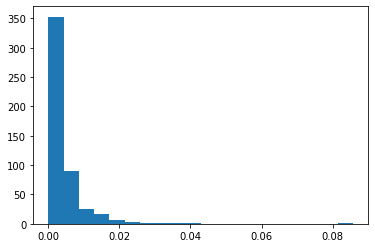

In [120]:
plt.hist(x, bins=20)
plt.show()

In [121]:
x.min()

0.00012093505262095613

In [122]:
x.max()

0.08559086951461047

In [ ]:
round(uniform(low, high) / q) * q

In [76]:
def quniform(low, high, q):
    out = np.round(np.random.uniform(low, high, 300)/q)*q
    return out

In [78]:
x = quniform(0, 2, 0.25)

In [79]:
x

array([0.5 , 1.75, 1.25, 1.25, 1.  , 1.25, 1.75, 0.5 , 0.  , 0.75, 2.  ,
       0.  , 0.  , 1.  , 0.25, 0.75, 1.5 , 0.  , 2.  , 1.  , 1.  , 1.25,
       1.75, 0.5 , 0.5 , 1.75, 1.25, 1.  , 1.  , 1.25, 0.25, 0.75, 1.  ,
       0.75, 1.75, 0.75, 0.75, 1.5 , 0.25, 0.25, 1.75, 1.  , 0.25, 0.25,
       0.75, 0.75, 0.25, 0.5 , 1.75, 2.  , 0.  , 0.  , 0.75, 0.  , 1.75,
       0.5 , 1.5 , 0.75, 1.75, 1.75, 0.5 , 1.5 , 1.5 , 0.5 , 0.75, 1.5 ,
       0.25, 2.  , 0.25, 1.25, 0.5 , 1.  , 1.5 , 1.75, 0.5 , 1.75, 1.75,
       1.25, 0.75, 2.  , 2.  , 0.5 , 0.75, 1.  , 0.75, 2.  , 0.  , 0.25,
       0.5 , 0.25, 0.5 , 0.25, 0.25, 1.  , 1.  , 1.75, 0.  , 1.  , 0.75,
       0.75, 0.25, 0.5 , 1.5 , 0.75, 1.5 , 0.25, 2.  , 1.25, 0.  , 1.  ,
       0.75, 1.25, 0.75, 0.75, 1.75, 1.25, 1.  , 0.  , 2.  , 0.5 , 1.75,
       1.5 , 0.25, 0.  , 1.75, 1.25, 0.  , 0.25, 0.5 , 1.75, 0.75, 1.25,
       1.25, 0.25, 0.25, 0.5 , 0.75, 0.5 , 1.75, 0.5 , 0.75, 0.25, 1.75,
       0.25, 1.75, 0.5 , 2.  , 0.25, 1.5 , 1.25, 1.

In [81]:
f = open('file.txt','w')

In [82]:
f

<_io.TextIOWrapper name='file.txt' mode='w' encoding='UTF-8'>

In [ ]:
f.write("" + "/n")